In [3]:
!pip install spleeter-gpu 

     |████████████████████████████████| 10.5MB 13.5MB/s 
     |████████████████████████████████| 184kB 69.5MB/s 
     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 61kB 10.7MB/s 
  Created wheel for spleeter-gpu: filename=spleeter_gpu-2.0.2-cp36-none-any.whl size=49748 sha256=0c5bff22e4ce2955bb9e8b296598fe76c5463639c5ec536a6acd9a51150c1ba0
  Stored in directory: /root/.cache/pip/wheels/bb/e1/2a/6edae742c14eea79b65c33cfce92078a1cda58a7c0c16f208d
  Created wheel for librosa: filename=librosa-0.8.0-cp36-none-any.whl size=201375 sha256=f56f951e840964388e59a575568e393842bffc0d723a4e8b442a5d53c033a80d
  Stored in directory: /root/.cache/pip/wheels/ee/10/1e/382bb4369e189938d5c02e06d10c651817da8d485bfd1647c9
Successfully built spleeter-gpu librosa
  Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Found existing installation: librosa 0.6.3
    Uninstalling librosa-0.6.3:
      Suc

In [26]:
!pip install pyroomacoustics youtube-dl soundfile


In [10]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
from scipy import signal
import soundfile as sf
from scipy.io.wavfile import read
from scipy.io.wavfile import write

# **Setting Sound**

In [3]:
link = 'https://www.youtube.com/watch?v=eEQFgzF-qbQ&ab_channel=2Point9Records'
!rm -rf song.wav
!youtube-dl --extract-audio --audio-format wav --output "song.wav" $link
!rm -rf /content/output/song
!spleeter separate -i song.wav -p spleeter:4stems -o output

[youtube] eEQFgzF-qbQ: Downloading webpage
[youtube] eEQFgzF-qbQ: Downloading js player 03226028
[youtube] eEQFgzF-qbQ: Downloading js player 03226028
[download] Destination: song.wav
[download] 100% of 3.01MiB in 00:00
[ffmpeg] Post-process file song.wav exists, skipping
INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/4stems.tar.gz
INFO:spleeter:Validating archive checksum
INFO:spleeter:Extracting downloaded 4stems archive
INFO:spleeter:4stems model file(s) extracted
INFO:spleeter:File output/song/vocals.wav written succesfully
INFO:spleeter:File output/song/drums.wav written succesfully
INFO:spleeter:File output/song/bass.wav written succesfully
INFO:spleeter:File output/song/other.wav written succesfully


In [4]:
# specify signal source
fs1, signal1 = wavfile.read("/content/output/song/drums.wav")
fs2, signal2 = wavfile.read("/content/output/song/bass.wav")
fs3, signal3 = wavfile.read("/content/output/song/other.wav")
fs4, signal4 = wavfile.read("/content/output/song/vocals.wav")

# Convert to mono
signal1 = signal1[:,0]
signal2 = signal2[:,0]
signal3 = signal3[:,0]
signal4 = signal4[:,0]


In [184]:
!rm -rf experimental_Results/
!mkdir experimental_Results

# 2D Room

In [193]:
# x=[0,2,7,9] 
# y=[9,9,9,9] 
# mic=[5,0]
# r=10

In [203]:
x=[0,2,7,9] 
y=[6,6,6,6] 
mic=[5,0]
r=7

In [204]:
# x=[0,2,7,9] 
# y=[3,3,3,3] 
# mic=[5,0]
# r=4

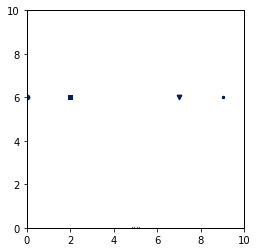

In [205]:
# add source to 2D room
# ["hard_surface" "brickwork" "reverb_chamber" "limestone_wall"]

m = pra.Material(energy_absorption="limestone_wall")
rt60_tgt = 0.3  # seconds  # The desired reverberation time and dimensions of the room in meter
room_dim = [10, 10]
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)


# Creating the Room
room = pra.ShoeBox(
     room_dim, fs=fs1, materials=pra.Material(e_absorption), max_order=max_order
)

# Add sources to the room
# Right to Left

room.add_source([x[0],y[0]], signal=signal1)
room.add_source([x[1],y[1]], signal=signal2)
room.add_source([x[2],y[2]], signal=signal3)
room.add_source([x[3],y[3]], signal=signal4)

R = pra.circular_2D_array(center=[mic[0],mic[1]], M=2, phi0=0, radius=0.1)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
fig, ax = room.plot()
room.simulate()

In [206]:
leftMic=room.mic_array.signals[0,:]
k=np.array(leftMic)
normalized_leftMic = np.array([(k / np.max(np.abs(k))) * 32767], np.int16)
!rm -rf left.wav
write("left.wav", fs1, normalized_leftMic.T)
# IPython.display.Audio(leftMic, rate=fs1)  # Play left channel

In [207]:
rightMic=room.mic_array.signals[1,:]
k=np.array(rightMic)
normalized_rightMic = np.array([(k / np.max(np.abs(k))) * 32767], np.int16)
!rm -rf right.wav
write("right.wav", fs1, normalized_rightMic.T)
# IPython.display.Audio(rightMic, rate=fs1)  # Play right channel

In [208]:
!rm -rf /content/output/right
!spleeter separate -i right.wav -p spleeter:4stems -o output
!rm -rf /content/output/left
!spleeter separate -i left.wav -p spleeter:4stems -o output


INFO:spleeter:File output/right/vocals.wav written succesfully
INFO:spleeter:File output/right/drums.wav written succesfully
INFO:spleeter:File output/right/bass.wav written succesfully
INFO:spleeter:File output/right/other.wav written succesfully
INFO:spleeter:File output/left/vocals.wav written succesfully
INFO:spleeter:File output/left/drums.wav written succesfully
INFO:spleeter:File output/left/bass.wav written succesfully
INFO:spleeter:File output/left/other.wav written succesfully


In [209]:
def lag_finder(y1, y2, sr):
    n = len(y1)

    corr = signal.correlate(y2, y1, mode='same') / np.sqrt(signal.correlate(y1, y1, mode='same')[int(n/2)] * signal.correlate(y2, y2, mode='same')[int(n/2)])

    delay_arr = np.linspace(-0.5*n/sr, 0.5*n/sr, n)
    delay = delay_arr[np.argmax(corr)]
    # print('y2 is ' + str(delay) + ' behind y1')

    # plt.figure()
    # plt.plot(delay_arr, corr)
    # plt.title('Lag: ' + str(np.round(delay, 3)) + ' s')
    # plt.xlabel('Lag')
    # plt.ylabel('Correlation coeff')
    # plt.show()
    return delay


def location(a,b):
  position=[]
  p = np.array(tuple(zip(a[:,0], b[:,0])))
  c = 343.    # speed of sound
  fs = 44100  # sampling frequency
  nfft = 256  # FFT size


  azimuth = np.array([61., 270.]) / 180. * np.pi
  X = pra.transform.stft.analysis(p, nfft, nfft // 2)
  X = X.transpose([2, 1, 0])
  
  doa = pra.doa.MUSIC(R, fs, nfft)
  doa.locate_sources(X, freq_bins=np.arange(20, 40))
  position.append(doa.grid.find_peaks(k=1)[0])
  # doa.grid.plot(mark_peaks=1)

  doa = pra.doa.SRP(R, fs, nfft)
  doa.locate_sources(X, freq_bins=np.arange(20, 40))
  position.append(doa.grid.find_peaks(k=1)[0])
  # doa.grid.plot(mark_peaks=1)

  doa = pra.doa.CSSM(R, fs, nfft)
  doa.locate_sources(X, freq_bins=np.arange(20, 40))
  position.append(doa.grid.find_peaks(k=1)[0])
  # doa.grid.plot(mark_peaks=1)

  doa = pra.doa.WAVES(R, fs, nfft)
  doa.locate_sources(X, freq_bins=np.arange(20, 40))
  position.append(doa.grid.find_peaks(k=1)[0])
  # doa.grid.plot(mark_peaks=1)

  doa = pra.doa.TOPS(R, fs, nfft)
  doa.locate_sources(X, freq_bins=np.arange(20, 40))
  position.append(doa.grid.find_peaks(k=1)[0])
  # doa.grid.plot(mark_peaks=1)

  return position


stem=['drums','bass','other','vocals']
resultDOA=[]
lag=[]
sr=44100
for i in stem:
  print(i)
  a=read("/content/output/right/"+i+".wav")
  a=np.array(a[1],dtype=float)
  b=read("/content/output/left/"+i+".wav")
  b=np.array(b[1],dtype=float)
  resultDOA.append(location(a,b))
  lag.append(lag_finder(a[:,1] , b[:,1], sr))

print(resultDOA)
print(lag)


drums
bass
other
vocals
[[287, 86, 199, 101, 294], [90, 270, 182, 352, 270], [270, 270, 271, 203, 270], [345, 87, 340, 265, 242]]
[0.0003741497048679321, 0.00017006804766594996, -0.00021541952703785228, -0.00030612248579586776]


In [210]:
f = open("experimental_Results/"+str(r)+".txt", "a")
f.writelines(["x="+str(x),"\ny=",str(y),"\nAlgo=",str(algo),"\nmic=",str(mic),"\nResult=",str(resultDOA),"\nLag",str(lag)])
f.close()
# print(x) 
# print(y)
# algo=['MUSIC','SRP','CSSM','WAVES','TOPS']
# print(mic)
# print(resultDOA)
# print(lag)


In [212]:
from google.colab import files
!zip -r limestone_wall.zip experimental_Results
files.download("/content/limestone_wall.zip")

  adding: experimental_Results/ (stored 0%)
  adding: experimental_Results/7.txt (deflated 31%)
  adding: experimental_Results/4.txt (deflated 31%)
  adding: experimental_Results/10.txt (deflated 32%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>